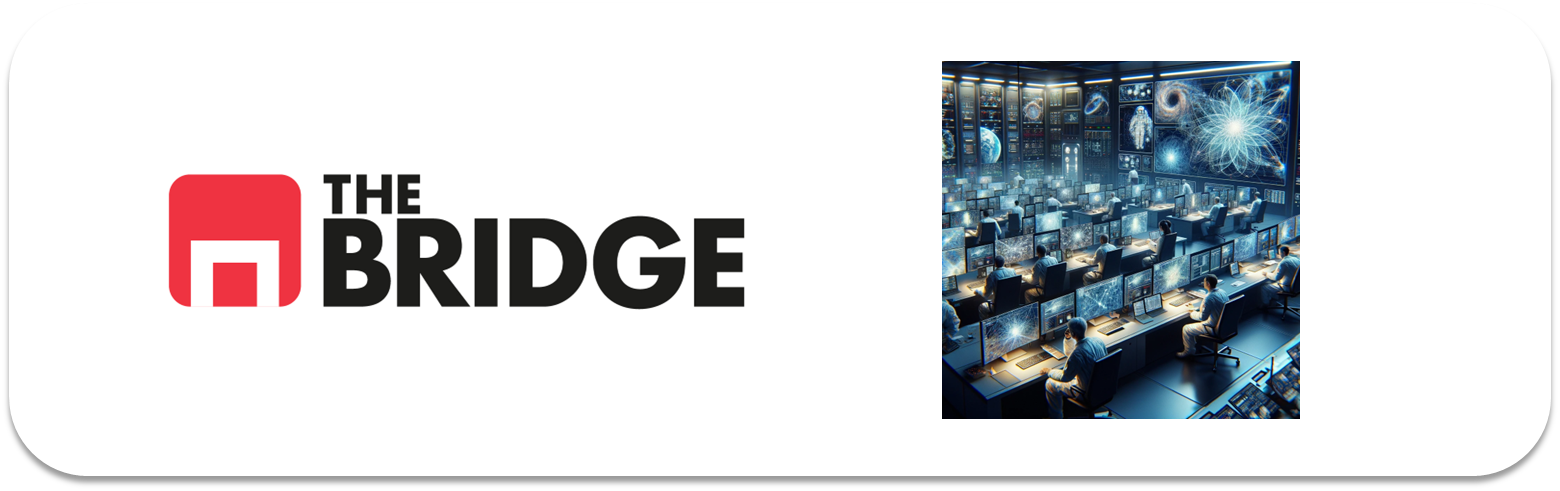

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import cv2
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import os
from sklearn.utils import shuffle
from skimage.io import imread
import zipfile

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



##### Preparamos los datos y las funciones

In [2]:
!mkdir data #creamos directorio en la misma carpeta del notebook

In [3]:
#Hemos copiado los archivos del ejercicio de la unidad anterior como se pide
#Descomprimimos y volcamos en la carpeta creada
path_to_zip_file = "./archive.zip"
directory_to_extract_to = "./data/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [2]:
#Traemos las funciones utilizadas en el workout anterior

def read_data(directorio, reshape_dim = (32,32)): 
    ''' Para leer directorios y archivos.
        Devuelve un array de X con los archivos y otro array para y con las etiquetas. 
    '''
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)


def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    ''' Pinta las imagenes contenidas en un set.
        args:
        paisajes: set de imagenes [indice]
        names: (etiquetas) set de etiquetas [indice]
        n_cols =5 por defecto
        size_scale = 2 por defecto
    '''
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [3]:
# Implementamos las funciones para obtener set de X e y además de comprobar que las imagenes se leen bien y están bien etiquetadas

# Instanciamos el path para la función:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/seg_test/"

X_train, y_train =  read_data(TRAIN_PATH)
x_test, y_test = read_data(TEST_PATH)

print(X_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street
(14034, 32, 32, 3) (14034,)
(3000, 32, 32, 3) (3000,)


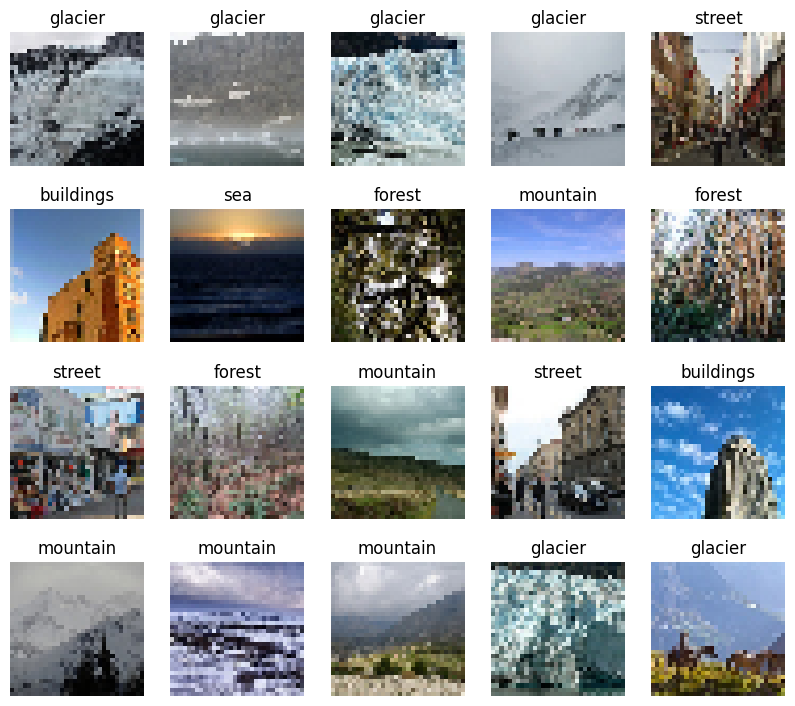

In [6]:
#leemos un conjunto de imágenes:
indices = np.random.randint(10,len(X_train),20) #generamos un indice aleatorio de 20 imágenes, desde la imagen 10 hasta el final del set 
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

##### Visualización de target y preparacion de los datos

In [4]:
target = pd.Series(y_train)
target.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [5]:
#Normalizamos:

X_train = X_train/255
x_test = x_test/255

In [6]:
#Barajamos para que no aprenda los datos en orden y pueda generalizar mejor
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

In [7]:
#Codificamos las categorías para poder pasarlas como etiquetas en el modelo:

etiquetas = np.unique(y_train)
n_etiquetas = len(etiquetas)
n_etiquetas

6

In [18]:
mapeo = {etiqueta : indice for indice, etiqueta in enumerate(etiquetas)} #hacemos un diccionario de comprension para emparejar a cada etiqueta con su indice que será a su vez el código numérico asignado
y_train_codif = np.array([mapeo[etiqueta] for etiqueta in y_train_shuffled])
y_test_codif = np.array([mapeo[etiqueta] for etiqueta in y_test])

#comprobamos
print(mapeo)
print(y_train_codif[0:5])
print(y_train_shuffled[0:5])

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
[0 5 5 4 3]
['buildings' 'street' 'street' 'sea' 'mountain']


##### Elegimos ResNetV50 como modelo preestablecido

In [9]:
model = ResNet50V2(input_shape=(32,32,3),
                   include_top= False, #porque vamos a aplicar nuestras propias capas densas
                   weights= 'imagenet', #lo entrenamos con los pesos de este dataset
                   classifier_activation= 'softmax') #porque tendrá varias salidas

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [10]:
#congelamos sus capas para que no se entrenen:
for layer in model.layers:
    layer.trainable = False 

In [12]:
#añadimos nuestras capas:
capa = keras.layers.Flatten()(model.output)
capa = keras.layers.Dense(150, activation='relu')(capa)
capa = keras.layers.Dropout(0.35)(capa)
capa = keras.layers.Dense(6, activation='softmax')(capa)

#las aplicamos al modelo:
model_tl = keras.models.Model(model.input, capa)

model_tl.compile(optimizer='adam',
                 loss= 'sparse_categorical_crossentropy',
                 metrics= ['accuracy'])

In [13]:
model_tl.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 23,873,056 (91.07 MB)

 Trainable params: 308,256 (1.18 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

##### Entrenamiento:

In [20]:
#primero una epoca para ver cuanto tarda:
model_tl_history = model_tl.fit(X_train_shuffled, 
                                y_train_codif,
                                validation_split= 0.2,
                                batch_size= 32,
                                epochs=1,
                                steps_per_epoch=100
                                )

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.3431 - loss: 1.6228 - val_accuracy: 0.4624 - val_loss: 1.3991


In [22]:
#earlystopping = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [24]:
model_tl_history = model_tl.fit(X_train_shuffled, 
                                y_train_codif,
                                validation_split= 0.2,
                                batch_size= 32,
                                epochs=50,
                                steps_per_epoch=100)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.4938 - loss: 1.3600 - val_accuracy: 0.4909 - val_loss: 1.3238
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.4999 - loss: 1.2946 - val_accuracy: 0.5077 - val_loss: 1.2749
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.5279 - loss: 1.2433 - val_accuracy: 0.5248 - val_loss: 1.2319
Epoch 4/50
 51/100 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.4889 - loss: 1.2545

c:\Users\bnove\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


KeyboardInterrupt: 

In [25]:
#para arreglar el error de que no haya datos suficientes, dejamos el hiperparámetro steps_per_epoch en automatico:
model_tl_history = model_tl.fit(X_train_shuffled, 
                                y_train_codif,
                                validation_split= 0.2,
                                batch_size= 32,
                                epochs=50)

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 43s 124ms/step - accuracy: 0.5532 - loss: 1.1500 - val_accuracy: 0.5411 - val_loss: 1.2035
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.5869 - loss: 1.0701 - val_accuracy: 0.5440 - val_loss: 1.1933
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.6108 - loss: 1.0043 - val_accuracy: 0.5426 - val_loss: 1.1974
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.6377 - loss: 0.9475 - val_accuracy: 0.5536 - val_loss: 1.2102
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.6498 - loss: 0.9096 - val_accuracy: 0.5458 - val_loss: 1.2221
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.6668 - loss: 0.8774 - val_accuracy: 0.5540 - val_loss: 1.2389
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.6829 - loss: 0.8333 - val_accuracy: 0.5476 - val_loss: 1.2622
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.6993 - loss: 0.7911

*No da buenos resultados, hay sobreajuste desde el principio y no mejora a medida que realiza epocas. Tampoco hemos puesto earlystoping y en este caso, sí deberíamos haberlo incluido*

##### Evaluacion:

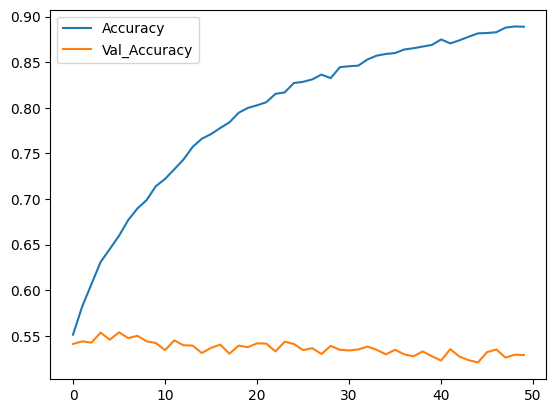

In [27]:
df_history_tl = pd.DataFrame(model_tl_history.history)
plt.plot(df_history_tl['accuracy'], label= 'Accuracy')
plt.plot(df_history_tl['val_accuracy'], label= 'Val_Accuracy')
plt.legend();

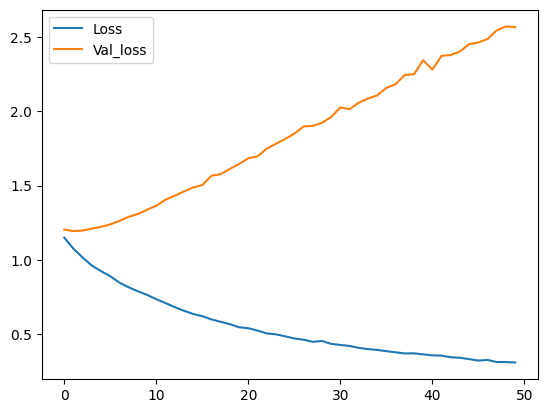

In [28]:
plt.plot(df_history_tl['loss'], label= 'Loss')
plt.plot(df_history_tl['val_loss'], label= 'Val_loss')
plt.legend();

In [29]:
model_tl.evaluate(x_test, y_test_codif)

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5401 - loss: 2.5357


[2.5495517253875732, 0.5246666669845581]

In [31]:
y_pred = [np.argmax(prediccion) for prediccion in model_tl.predict(x_test)]
prediccion = classification_report(y_test_codif, y_pred)
print(prediccion)

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step
              precision    recall  f1-score   support

           0       0.45      0.49      0.47       437
           1       0.72      0.69      0.71       474
           2       0.49      0.50      0.50       553
           3       0.48      0.49      0.49       525
           4       0.54      0.52      0.53       510
           5       0.48      0.46      0.47       501

    accuracy                           0.52      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.53      0.52      0.53      3000



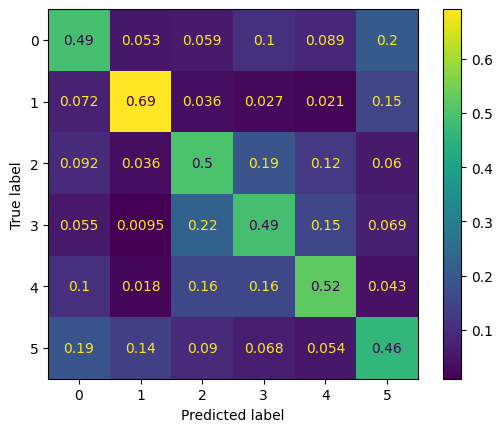

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test_codif, y_pred, normalize='true')

##### Fine-Tunning

In [54]:
model_ft_base = ResNet50V2(input_shape=(32,32,3),
                   include_top= False, 
                   weights= None, #para que no entrene con los pesos preestablecidos
                   classifier_activation= 'softmax')

#no congelamos capas
#usamos las misma red de capas que en el primero modelado construida con API funcional:
capa = keras.layers.Flatten()(model_ft_base.output)
capa = keras.layers.Dense(150, activation='relu')(capa)
capa = keras.layers.Dropout(0.35)(capa)
capa = keras.layers.Dense(6, activation='softmax')(capa)

#las aplicamos al modelo:
model_ft = keras.models.Model(model_ft_base.input, capa)

model_ft.compile(keras.optimizers.Adam(learning_rate=0.01), #añadimos penalización
                 loss= 'sparse_categorical_crossentropy',
                 metrics= ['accuracy'])


In [55]:
model_ft.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 23,873,056 (91.07 MB)

 Trainable params: 23,827,616 (90.90 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [38]:
# esta vez añadiremos un earlystopping:
earlystopping = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [53]:
X_train_shuffled.shape

(14034, 32, 32, 3)

In [56]:
model_ft_history = model_ft.fit(X_train_shuffled, y_train_codif, 
                                validation_split= 0.2,
                                batch_size= 32,
                                epochs=50,
                                callbacks=earlystopping)

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 111s 232ms/step - accuracy: 0.2358 - loss: 2.6420 - val_accuracy: 0.1685 - val_loss: 1.9156
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 221ms/step - accuracy: 0.3089 - loss: 1.5616 - val_accuracy: 0.3174 - val_loss: 1.3933
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 212ms/step - accuracy: 0.3365 - loss: 1.4388 - val_accuracy: 0.2754 - val_loss: 1.9429
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 239ms/step - accuracy: 0.3764 - loss: 1.3543 - val_accuracy: 0.1696 - val_loss: 2.1791
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 215ms/step - accuracy: 0.3988 - loss: 1.3274 - val_accuracy: 0.4083 - val_loss: 1.5325
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.4413 - loss: 1.3032 - val_accuracy: 0.1771 - val_loss: 2.1244
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - accuracy: 0.4843 - loss: 1.2724 - val_accuracy: 0.4307 - val_loss: 1.6533
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.5231 - loss: 

#### Evaluación

In [57]:
model_ft.evaluate(x_test, y_test_codif)

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.6493 - loss: 0.9276


[0.8772939443588257, 0.6576666831970215]

*Parece que no ha mejorado mucho y sigue teniendo un valor de pérdida en validación muy alto*

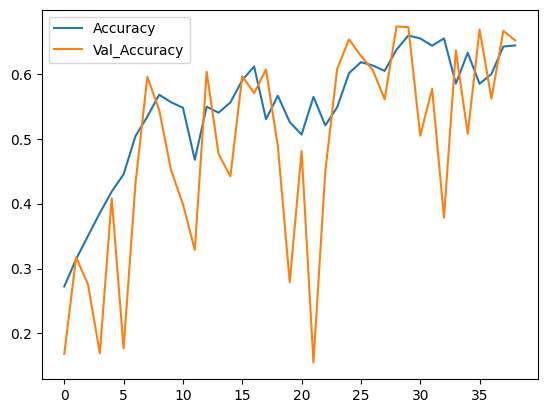

In [59]:
df_history_ft = pd.DataFrame(model_ft_history.history)
plt.plot(df_history_ft['accuracy'], label= 'Accuracy')
plt.plot(df_history_ft['val_accuracy'], label= 'Val_Accuracy')
plt.legend();

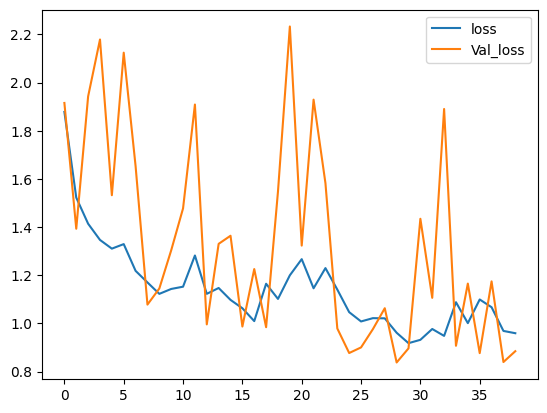

In [61]:
plt.plot(df_history_ft['loss'], label= 'loss')
plt.plot(df_history_ft['val_loss'], label= 'Val_loss')
plt.legend();

In [62]:
y_pred_ft = [np.argmax(prediccion) for prediccion in model_ft.predict(x_test)]
prediccion_ft = classification_report(y_test_codif, y_pred_ft)
print(prediccion_ft)

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step
              precision    recall  f1-score   support

           0       0.70      0.53      0.60       437
           1       0.87      0.82      0.84       474
           2       0.61      0.72      0.66       553
           3       0.58      0.77      0.66       525
           4       0.56      0.30      0.39       510
           5       0.67      0.79      0.73       501

    accuracy                           0.66      3000
   macro avg       0.66      0.66      0.65      3000
weighted avg       0.66      0.66      0.65      3000



In [64]:
print(mapeo)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


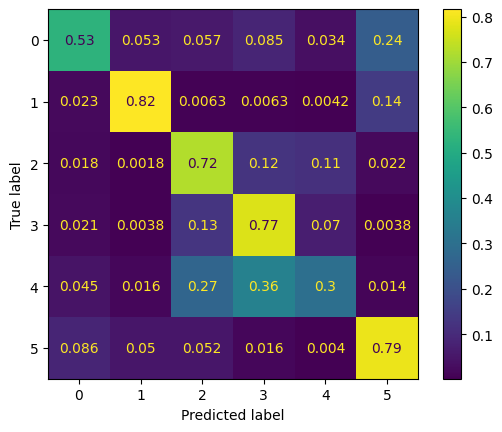

In [63]:
ConfusionMatrixDisplay.from_predictions(y_test_codif, y_pred_ft, normalize='true')

*Es ligeramente mejor con el fine-tunning, pero sigue teniendo mucho margen de mejora*

##### Comparación con modelo sin transfer learning

*El modelo actual lo hace peor (66% accuracy) frente a un 79% de accuracy que obtuvo el modelo realizado en la unidad anterior sin transfer learning.*  
*Un posible aspecto de mejora sería usar un generador de imágenes y probar si con datos sintéticos en train y validació generaliza mejor y un valor de pérdida tan alto*